In [ ]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv

In [84]:
import pandas as pd

df = pd.read_csv("course_lead_scoring.csv")
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [85]:
df.isna().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [102]:
str_columns = list(df.columns[df.dtypes == object])
numerical_columns = list(df.columns[df.dtypes != object])

numerical_columns = numerical_columns[:-1]
numerical_columns

['number_of_courses_viewed',
 'annual_income',
 'interaction_count',
 'lead_score']

In [87]:
df[str_columns] = df[str_columns].fillna("NA")
df[numerical_columns] = df[numerical_columns].fillna(0.0)

In [88]:
df.isna().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [ ]:
y = df.converted.values
df.drop(columns=["converted"], inplace=True)

df.head()

In [36]:
from sklearn.preprocessing import MinMaxScaler

norm_lead_score = MinMaxScaler().fit_transform(df[["lead_score"]]).round()
norm_number_of_courses_viewed = MinMaxScaler().fit_transform(df[["number_of_courses_viewed"]]).round()
norm_interaction_count = MinMaxScaler().fit_transform(df[["interaction_count"]]).round()
norm_annual_income = MinMaxScaler().fit_transform(df[["annual_income"]]).round()

In [40]:
y

array([1, 0, 1, ..., 1, 1, 1], shape=(1462,))

In [48]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y, norm_lead_score, pos_label=1)
print(auc(fpr, tpr))
fpr, tpr, thresholds = roc_curve(y, norm_number_of_courses_viewed, pos_label=1)
print(auc(fpr, tpr))
fpr, tpr, thresholds = roc_curve(y, norm_interaction_count, pos_label=1)
print(auc(fpr, tpr))
fpr, tpr, thresholds = roc_curve(y, norm_annual_income, pos_label=1)
print(auc(fpr, tpr))

0.5866986718509776
0.5526934941527719
0.5536605929555531
0.5383635696360733


In [19]:
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse=False)
dicts = df.to_dict(orient="records")

X = dv.fit_transform(dicts)
X

array([[7.9450e+04, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 1.0000e+00,
        1.0000e+00],
       [4.6992e+04, 0.0000e+00, 1.0000e+00, ..., 0.0000e+00, 1.0000e+00,
        1.0000e+00],
       [7.8796e+04, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        5.0000e+00],
       ...,
       [4.5688e+04, 0.0000e+00, 0.0000e+00, ..., 1.0000e+00, 0.0000e+00,
        1.0000e+00],
       [7.1016e+04, 0.0000e+00, 0.0000e+00, ..., 1.0000e+00, 0.0000e+00,
        5.0000e+00],
       [9.2855e+04, 0.0000e+00, 0.0000e+00, ..., 1.0000e+00, 0.0000e+00,
        3.0000e+00]], shape=(1462, 31))

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_other, y_train, y_other = train_test_split(X, y, train_size=0.6, random_state=1)
X_test, X_val, y_test, y_val = train_test_split(X_other, y_other, train_size=0.5, random_state=1)

In [28]:
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((877, 31), (292, 31), (293, 31), (877,), (292,), (293,))

In [49]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [ ]:
pred_val = model.predict(X_val)

fpr, tpr, thresholds = roc_curve(y_val, pred_val, pos_label=1)
round(auc(fpr, tpr), 3)

0.659

In [53]:
import numpy as np

/Users/purujitb/workspace/ml-zoomcamp-hw/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/purujitb/workspace/ml-zoomcamp-hw/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


<Axes: >

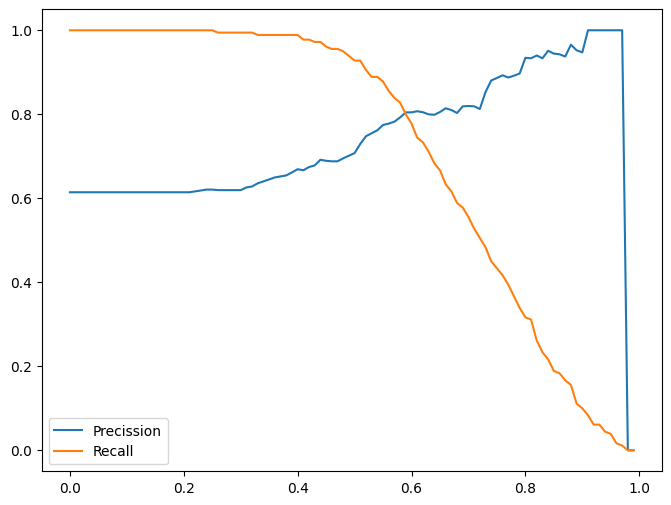

In [65]:
from sklearn.metrics import precision_score, recall_score

def get_pr(X_val, y_val, threshold):
    pred_val = (model.predict_proba(X_val)[:, 1] >= threshold).astype(int)
    precision = precision_score(y_val, pred_val)
    recall = recall_score(y_val, pred_val)

    return (precision, recall)


import seaborn as sns
import matplotlib.pyplot as plt

thresholds = np.arange(0.0, 1.0, 0.01)
p_a = []
r_a = []
for t in thresholds:
    p, r = get_pr(X_val, y_val, t)
    p_a.append(p)
    r_a.append(r)

plt.figure(figsize=(8, 6))
sns.lineplot(x=thresholds, y=p_a, label='Precission')
sns.lineplot(x=thresholds, y=r_a, label='Recall')

In [82]:
F_a = 2 * np.multiply(p_a, r_a)/(np.add(p_a, r_a))
print(np.argmin(F_a))
F_a, min(F_a)


98


/var/folders/ds/6hryjbzj5g75d79xz48df3hh0000gn/T/ipykernel_77395/4166354611.py:1: RuntimeWarning: invalid value encountered in divide
  F_a = 2 * np.multiply(p_a, r_a)/(np.add(p_a, r_a))


(array([0.76109937, 0.76109937, 0.76109937, 0.76109937, 0.76109937,
        0.76109937, 0.76109937, 0.76109937, 0.76109937, 0.76109937,
        0.76109937, 0.76109937, 0.76109937, 0.76109937, 0.76109937,
        0.76109937, 0.76109937, 0.76109937, 0.76109937, 0.76109937,
        0.76109937, 0.76109937, 0.76271186, 0.76433121, 0.76595745,
        0.76595745, 0.76332623, 0.76332623, 0.76332623, 0.76332623,
        0.76332623, 0.76824034, 0.76989247, 0.77391304, 0.77729258,
        0.78070175, 0.78414097, 0.78587196, 0.78761062, 0.79287305,
        0.79820628, 0.79279279, 0.79818594, 0.79908676, 0.80831409,
        0.80278422, 0.8       , 0.8       , 0.8028169 , 0.80285036,
        0.80288462, 0.81662592, 0.81909548, 0.81632653, 0.82051282,
        0.82291667, 0.81481481, 0.80965147, 0.80978261, 0.80222841,
        0.79096045, 0.77456647, 0.76744186, 0.75294118, 0.73652695,
        0.72948328, 0.7125    , 0.70031546, 0.67948718, 0.67752443,
        0.66225166, 0.64189189, 0.62328767, 0.61

In [103]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[str_columns + numerical_columns].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model):
    dicts = df[str_columns + numerical_columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [89]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

In [108]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=1)

n_splits = 5

for C in [0.000001, 0.001, 1]:
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kf.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        if "converted" in df_train:
            del df_train['converted']
        if "converted" in df_val:
            del df_val['converted']
        
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))



C=1e-06 0.561 +- 0.024
C=0.001 0.868 +- 0.019


/Users/purujitb/workspace/ml-zoomcamp-hw/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/purujitb/workspace/ml-zoomcamp-hw/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    htt

C=1 0.920 +- 0.012


/Users/purujitb/workspace/ml-zoomcamp-hw/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/purujitb/workspace/ml-zoomcamp-hw/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    htt